# Running a Single Fit with Manually-set Priors


In this example, we will show how to use builtin functions in `pysersic` as well as `numpyro.distributions` directly in order to set up your own priors for a fit. As a reminder, the `autoprior()` function should, in most cases, be able to determine a reasonable set of priors to begin sampling from, and the results are generally not sensitive to initializing anywhere close to to the MAP, as the MAP is found first automatically. 

That said,  you may have informed reasons for wanting to set certain priors. For this example, we'll use a single galaxy fit again, using the second galaxy from the example set from HSC:

In [1]:
import numpy as np 
def load_data(n):
    im = np.load(f'examp_gals/gal{n}_im.npy')
    mask = np.load(f'examp_gals/gal{n}_mask.npy')
    sig = np.load(f'examp_gals/gal{n}_sig.npy')
    psf = np.load(f'examp_gals/gal{n}_psf.npy')
    return im,mask,sig,psf 

im,mask,sig,psf = load_data(2)

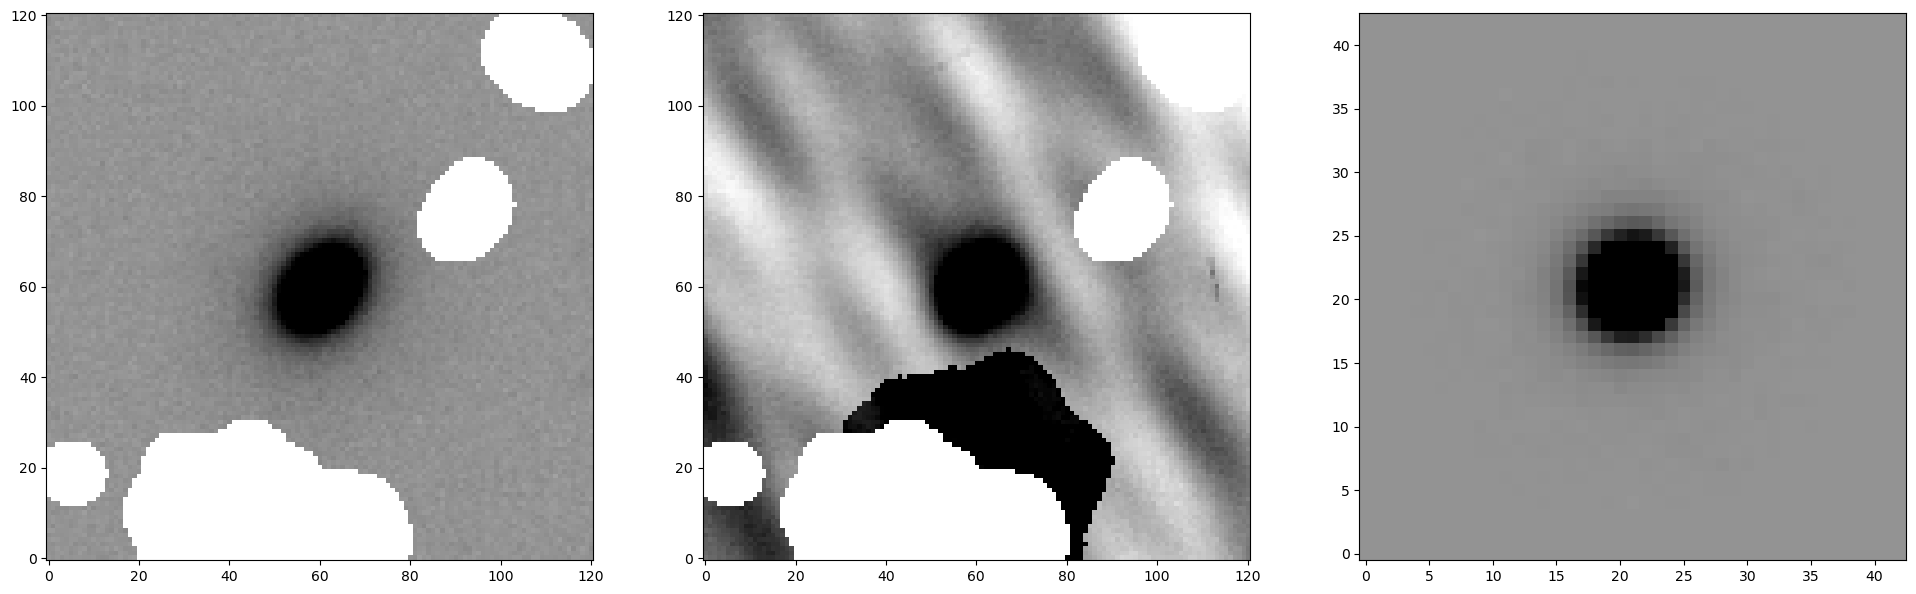

In [2]:
from pysersic.results import plot_image

fig, ax = plot_image(im,mask,sig,psf)

To begin, let's go ahead and run autoprior in order to get a good start-point estimate to build off of:

In [3]:
from pysersic.priors import autoprior 

prior = autoprior(im,profile_type='sersic',sky_type='flat',mask=mask)
prior

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
r_eff ---  Truncated Normal w/ mu = 6.71, sigma = 2.59, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Truncated Normal w/ mu = 2.00, sigma = 1.00, between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00

Now let's say we wanted to adjust some of these priors. For example, we can see by eye in our image that the ellipticity of this object is non-negligable, so perhaps we want to enforce a uniform prior between 0.2 and 0.9, instead of 0.0->0.9. 

(In practice this won't really make a difference, but let's do it to see how it is done.)

To set a prior, we will invoke one of several methods known to our prior object:

- `prior.set_gaussian_prior()`,
- `prior.set_uniform_prior()`,
- `prior.set_truncated_gaussian_prior()`,
- `prior.set_custom_prior()`.


The final instance of this list is different than the others, and allows us to insert arbitrary `numpyro.distributions`. But for our example, we want to set a uniform prior on `ellip` changing the lower bound. 

In [4]:
help(prior.set_uniform_prior)

Help on method set_uniform_prior in module pysersic.priors:

set_uniform_prior(var_name: str, low: float, high: float) -> 'PySersicSourcePrior' method of pysersic.priors.PySersicSourcePrior instance
    Set a uniform prior for a variable
    
    Parameters
    ----------
    var_name : str
        variable name
    low : float
        lower bound
    high : float
        upper bound
    
    Returns
    -------
    PySersicSourcePrior
        returns self to allow chaining



We can see that for this method, we simply need to provide the parameter name (`'ellip'` in this case), the low value, and the high value. Let's try it:

In [4]:
prior.set_uniform_prior('ellip',0.2,0.9)
prior

Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
r_eff ---  Truncated Normal w/ mu = 6.71, sigma = 2.59, between: 0.50 -> inf
ellip ---  Uniform between: 0.20 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Truncated Normal w/ mu = 2.00, sigma = 1.00, between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00

As we can see, we've successfully updated the prior for `'ellip'` to be from 0.2 to 0.9. 

Hopefully, gaussian/truncated gaussian and uniform priors are sufficient for your fitting needs (for most galaxy-fitting, they should), but we can look at how to implement a specific custom prior just in case. 

In [5]:
help(prior.set_custom_prior)

Help on method set_custom_prior in module pysersic.priors:

set_custom_prior(var_name: str, prior_dist: numpyro.distributions.distribution.Distribution, reparam: Optional[numpyro.infer.reparam.Reparam] = None) -> 'PySersicSourcePrior' method of pysersic.priors.PySersicSourcePrior instance
    Set a custom distribution as the prior for a given variable
    
    Parameters
    ----------
    var_name : str
        variable name
    prior_dist : dist.Distribution
        Numpyro Distribution object describing prior
    reparam : Optional[infer.reparam.Reparam], optional
        Optional reparamaterization to use for variable, by default None
    
    Returns
    -------
    PySersicSourcePrior
        Returns self to allow chaining



As we can see, now we input the var name, but also a full `prior_dist`, which is a `numpyro.dist.Distribution`. 

As an example, let's try replacing the Normal prior on the flux with, say, a Cauchy... for some reason. To do this, we use the following format, establishing a transformed distribution:

In [5]:
from numpyro import distributions as dist,infer

prior_dist = dist.TransformedDistribution(
            dist.Cauchy(),
            dist.transforms.AffineTransform(loc=3689.19,scale=80),)
reparam = infer.reparam.TransformReparam()
prior.set_custom_prior('flux',prior_dist,reparam=reparam)


Prior for a sersic source:
--------------------------
flux ---  Custom prior of type: <class 'numpyro.distributions.distribution.TransformedDistribution'>
r_eff ---  Truncated Normal w/ mu = 6.71, sigma = 2.59, between: 0.50 -> inf
ellip ---  Uniform between: 0.20 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Truncated Normal w/ mu = 2.00, sigma = 1.00, between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00

Again, we can see in our `__repr__` that the flux prior has been replaced by our Cauchy distribution. The full list of `numpyro` distributions can be found [here](https://num.pyro.ai/en/stable/distributions.html). 

Let's set up a fitter and try to fit this thing. Instead of fully sampling, I'm going to use the laplace approximation here, estimating the posterior as a gaussian around the MAP value.

In [6]:
from pysersic import FitSingle
from pysersic.loss import student_t_loss

fitter = FitSingle(data=im,rms=sig,mask=mask,psf=psf,prior=prior,loss_func=student_t_loss)

res = fitter.estimate_posterior(method='laplace')
res

  3%|▎         | 101/3000 [00:00<00:05, 523.10it/s, Round = 3,step_size = 1.6e-03 log(-loss): 9.3334]
/Users/ipasha/Dropbox/github/pysersic/pysersic/results.py:126: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  post_raw = svi_res_dict['guide'].sample_posterior(rkey, svi_res_dict['svi_result'].params, sample_shape = ((1000,)))


PySersicResults object for pysersic fit of type: svi

In [7]:
res.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip,0.213,0.0,0.213,0.213,0.0,0.0,1000.0,1000.0,NaN
flux,3792.196,0.0,3792.196,3792.196,0.0,0.0,1000.0,1000.0,NaN
n,7.764,0.0,7.764,7.764,0.0,0.0,1000.0,1000.0,NaN
r_eff,8.930,0.0,8.930,8.930,0.0,0.0,1000.0,1000.0,NaN
sky_back,0.003,0.0,0.003,0.003,0.0,0.0,1000.0,1000.0,NaN
theta,0.817,0.0,0.817,0.817,0.0,0.0,1000.0,1000.0,NaN
xc,60.162,0.0,60.162,60.162,0.0,0.0,1000.0,1000.0,NaN
yc,58.802,0.0,58.802,58.802,0.0,0.0,1000.0,1000.0,NaN


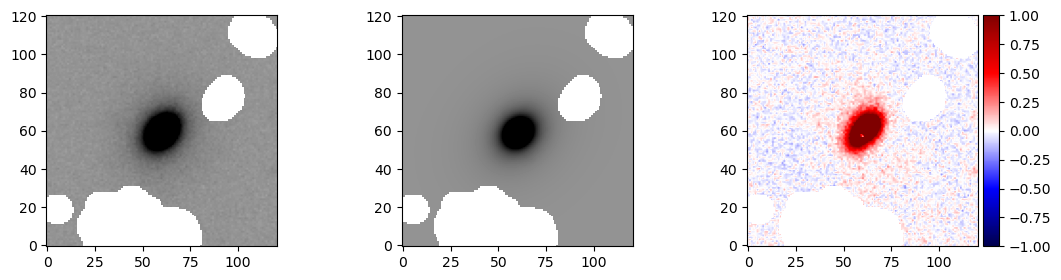

In [9]:
from pysersic.results import plot_residual
mod = res.get_median_model()
fig, ax = plot_residual(im,mod[1],mask=mask,vmin=-1,vmax=1)

Welp! It looked like that prior choice didn't do a great job. Let's confirm the automatically selected, more reasonable priors do:

In [10]:
prior = autoprior(im,profile_type='sersic',sky_type='flat',mask=mask)
prior


Prior for a sersic source:
--------------------------
flux ---  Normal w/ mu = 3689.19, sigma = 121.48
r_eff ---  Truncated Normal w/ mu = 6.71, sigma = 2.59, between: 0.50 -> inf
ellip ---  Uniform between: 0.00 -> 0.90
theta ---  Custom prior of type: <class 'numpyro.distributions.directional.VonMises'>
n ---  Truncated Normal w/ mu = 2.00, sigma = 1.00, between: 0.50 -> 8.00
xc ---  Normal w/ mu = 60.39, sigma = 1.00
yc ---  Normal w/ mu = 59.29, sigma = 1.00

In [11]:
fitter = FitSingle(data=im,rms=sig,mask=mask,psf=psf,prior=prior,loss_func=student_t_loss)

res = fitter.estimate_posterior(method='laplace')

  4%|▎         | 108/3000 [00:00<00:05, 514.84it/s, Round = 3,step_size = 1.6e-03 log(-loss): 9.5583]
/Users/ipasha/Dropbox/github/pysersic/pysersic/results.py:126: UserWarning: Hessian of log posterior at the MAP point is singular. Posterior samples from AutoLaplaceApproxmiation will be constant (equal to the MAP point). Please consider using an AutoNormal guide.
  post_raw = svi_res_dict['guide'].sample_posterior(rkey, svi_res_dict['svi_result'].params, sample_shape = ((1000,)))


In [13]:
res.summary()

arviz - WARNING - Shape validation failed: input_shape: (1, 1000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
ellip,0.294,0.000,0.294,0.294,0.0,0.0,1000.0,1000.0,NaN
flux,4935.034,0.000,4935.035,4935.035,0.0,0.0,1000.0,1000.0,NaN
n,7.985,0.000,7.985,7.985,0.0,0.0,1000.0,1000.0,NaN
r_eff,7.089,0.000,7.089,7.089,0.0,0.0,1000.0,1000.0,NaN
sky_back,-0.013,0.000,-0.013,-0.013,0.0,0.0,1000.0,1000.0,NaN
theta,0.890,0.000,0.890,0.890,0.0,0.0,1000.0,1000.0,NaN
xc,60.368,0.009,60.349,60.384,0.0,0.0,976.0,981.0,NaN
yc,59.242,0.010,59.224,59.260,0.0,0.0,932.0,867.0,NaN


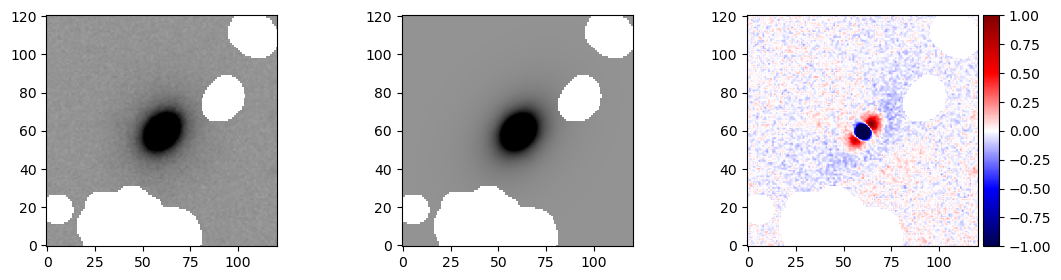

In [12]:
mod = res.get_median_model()
fig, ax = plot_residual(im,mod[1],mask=mask,vmin=-1,vmax=1)

There are clearly residuals, but this appears to be a result of this galaxy having internal structure (e.g., a resolved bulge) that a single sersic profile cannot handle. 